<a href="https://colab.research.google.com/github/ACSE-ecm22/L1TestRepo/blob/main/Actually_most_up_to_date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1dFgNX9iQUfmBOdmUN2-H8rPxL3SLXmxn" width="400"/>


---


### ***Name***: [*your name goes here*]
### ***CID***: [*your CID goes here*]

# Instructions:

Follow the instructions below to complete the coursework and submit it:

<br>

1. Complete your coursework using this provided Jupyter Notebook template (use Google Colab or your local machine if it has a GPU and/or sufficient computational power). Your copy of the notebook should be named: `yourusername_coursework_I.ipynb`. And don't forget to fill in the two fields at the top of this notebook with your name and CID.

<br>

2. Once you have completed your answers, upload your final notebook to the repo you got from the github classroom link. Make sure to have all the answers in there:

   - **All the cells in your final Jupyter Notebook should be executed before saving and uploading to github in order to have the output of the cells available in the uploaded version** (images you plot, training graphs generated with `livelossplot`, etc). We will not rerun code blocks in the notebooks, it is your responsibility to run them before uploading the notebook.

   - Add comments in the code to explain what you are doing at every step. 

   - All answers requiring written answers (ie, not code) should be in markdown blocks in the Jupyter Notebook. This provided Jupyter Notebook template has allocated blocks for the questions, but **you can add any coding or markdown blocks you need**.

<br>

3. The coursework is released on **Friday 9 December at 14:00h UK time**, and the answers have to be submitted on **Monday 12 December, 20:00h UK time**. We will not accept late submissions.

<br>

<br>

### The coursework consists of 5 questions you have to complete. You will find them below. 

- Questions 2 and 3 are very similar and you have to complete both of them, **you DO NOT have to choose one of them, you have to do them both.**

- You can use code seen in class, but indicate clearly when you do, and **make it clear (using comments or markdown blocks) what are your modifications**. This will influence your final marks.

- Your final marks will depend both on the quality of your results **AND** the justification, explanation and rationale of your implementations.

- Reference any publications and other materials that you use, but keep in mind that **your implementations should be original and not copied from any online resources (we will check for plagiarism)**. It is ok to use other resources to understand concepts and draw inspiration, but always reference them properly in the notebook.

- Finally, **justify your answers well, but focus on what the question is asking**. I will penalise lengthy answers that do not have any relation with the question being addressed.

<br>

---

<br>

## Imports

In [2]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 595 kB 60.2 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [14]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla T4!


<br>

---

<br>

## **Q1** - Download and prepare the Fashion MNIST dataset [10 points]

Get the `FashionMNIST` dataset from `torchvision.datasets`

- Inspect the dataset and format the data as you see fit to use it in your next questions. Explain the process you follow.

- Plot a matrix of images with 10 examples of each class.

- Is the dataset well balanced (does it have similar number of samples for each class)? Generate and present data to support your answer in any form you see fit.

In [15]:
train_dataset = torchvision.datasets.FashionMNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./', train=False, download=True)

**Inspecting the Dataset**

We can see that there are equal amount of images from each class. This would support the idea that the dataset is balanced. Additionally, FMNIST is a well documented dataset used extensively in ML which would suggest that it would be balanced.

In [ ]:
print(type(train_dataset), "\n")
print(train_dataset, "\n")
print(dir(train_dataset))
train_labels = np.array(train_dataset.train_labels)
pd.DataFrame(train_labels)[0].value_counts()

<class 'torchvision.datasets.mnist.FashionMNIST'> 

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train 

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', '

**Plotting the classes**

Below are plots from all of the classes - I have used code from https://stackoverflow.com/questions/65528954/display-number-of-images-per-class-using-pytorch to help plot these.

In [ ]:
class_to_idx = list(train_dataset.class_to_idx.values())
examples = {i: [] for i in range(len(class_to_idx))}

n_examples = len(class_to_idx)

for idx in range(len(train_dataset)):
    x, y = train_dataset[idx]
    if all([len(ex) == n_examples for ex in examples.values()]):
        break
    if len(examples[y]) < n_examples:
        examples[y].append(idx)

#print(examples)

for cl, img_idx in examples.items():
  fig, axs = plt.subplots(1, 10, figsize=(15,15))
  for i, idx in enumerate(examples[cl]):
    x, y = train_dataset[idx]
    axs[i].imshow(x[0], cmap='gray')
    axs[i].set_title(f'{str(y)} - {class_to_idx[y]}')

text block for your answers

<br>

---

<br>

## **Q2** - Implement a **conditional VAE** [25 points]

Implement a VAE similar to the one we saw in class but with the following modifications:

- Your new network should generate samples of any class defined by the user, that is, when you run your decoder, you have to tell it which class you want it to generate. <br> *During the lectures we created a VAE that would generate samples of any class, we did not have control over which class would be generated. The exercise is to modify the network, training loops, and anything else you consider necessary, so that, once is trained, you can generate images of any particular class specified when you run your generative model.*

- Expand your network to include **at least two** of the following modifications. Choose them based on what you think will result in better network performance (make sure to justify your choices well, argumenting why did you decide to include your particular modifications):
  - Convolutional layers
  - Data augmentation 
  - Different activations
  - Different random seed
  - Other network modifications that are well justified. <br> *You have freedom to choose what to do here, but your marks will depend not only on the correct implementation but also on the justification of your choices.*

- Use your trained conditional VAE to **generate and plot 10 new samples of each class** by adding the class label to your random input (in any form you have implemented it).

- You **DO NOT** have to optimise any hyperparameters, but if you had to choose three hyperparameters to optimise:
  - Which ones would you choose and why?

Generate information of your training process (liveloss plots, or any other data that will help you understand your results and analyse them in the last question **Q4**).



I will start by creating a dataloader to handle the dataset

**Loading in Data with Augmentations**

We start by loading in the MNIST Dataset and applying transformations. We firstly transform the PIL images into Tensors. This allows us to perform computations on the image data on the GPU using cuda.

Secondly, we introduce some data augmentations.

*   RandomHorizontalFlip: this will flip the images randomally with a set probability (default p=0.5)
*   RandomRotation: this will rotate the image from the center by 2 degrees in our case.

I have introduced these to generate more synthetic data points from the exisiting data.

Note:

I have chose not to Normalise the data as a result of testing. I have found that both my cVAE model and cGAN model perform better without normalisation. I suspect that the FMNIST dataset already has a comparable scale, therefore normalising would eliminate this.



In [4]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(2)])
                                 #transforms.Normalize((0.1307,), (0.3081,))])#, transforms.RandomResizedCrop(28, scale=(0.675, 1.0))])

test_transforms = transforms.Compose([transforms.ToTensor()])
                                 #transforms.Normalize((0.1307,), (0.3081,))])                                

In [5]:
train_dataset = torchvision.datasets.FashionMNIST('./', train=True, transform=train_transforms, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./', train=False, transform=test_transforms, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



**Setting my Hyperparams**

I have experimented with the learning rate as this is the parameter that contributes to the effectiveness of the ADAM Optimizer. A range between 0.001 and 0.0005 seems to optimal for my model.

The hyperparameters I would choose to optimise are the Learning Rate, Batch Size and Weight Decay:

*   Learning Rate: As this controls the step size at each iteration, a very small LR would require more epochs to train, and risks getting stuck in a local minima. A high LR could also result in passing the global minima, therefore it's an important parameter.
*   Batch Size: the batch controls how many images and labels are passed on each pass of the network. This means that a small batch size would result in more frequent gradient updates. This coupled with the LR are both important to balance.
*   Weight Decay: the weight decay parameter of the ADAM optimiser applies L2 regularization which is important to prevent over/under fitting



I need to implement my Seed into the networks.

In [6]:
seed = 42
lr = 0.001
batch_size = 64
test_batch_size = 1000
n_epochs = 200
weight_decay = 1e-6

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

**One Hot Encoding the data Labels**

This function takes the datasets labels and encodes them into a 1D tensor of size([num_classes]). This is important as it will allow us to embed the label data into the image data.

This is a function I have used from https://github.com/dyedgreen/conditional-vae/blob/master/cvae.py

In [8]:
# Function source: https://github.com/dyedgreen/conditional-vae/blob/master/cvae.py

def idx_to_onehot(idx):
    one_hot = torch.zeros(idx.size(0), 10)
    for i in range(idx.size(0)):
        one_hot[i][idx[i]] = 1
    return one_hot.to(device)

**Building the Encoder**

My network architecture for my encoder includes convolutional layers that have been activated with GELU and ReLU activations. I have chosen these activations as they help reduces training times by setting any negative values to 0, thus reducing the complexity of the operation. Also ReLU and GeLU can be an effective solution to vanishing gradients. This is because the parital derivative of the ReLU function is 0 for negative values and 1 for positive, therefore the gradient can never be extremely small.

Because of the rigid nature of the ReLU activation, many nodes that have a gradient of zero are considered "dead". As such, I am still considering if inlcuding leaky ReLU may be a more effective solution as the gradient will be prevented from reaching zero.

I have also added batch normalisation in order to improve regualarisation of the network.

I have used convolutions in the as the first stages of the encoder in order to have the network observe the general relationship around the filters center pixel. The next part of the encoder is included in the combined network.



In [54]:
class VAE_Encoder_Conv(nn.Module): 
  def __init__(self):
    super(VAE_Encoder_Conv, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,  20, 3, padding=3),
        nn.GELU(),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(20)
    )  # Dims in 32x32 -> out 16x16

    self.layer2 = nn.Sequential(
        nn.Conv2d(20, 40, 3, padding="same"),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(40)
    )  # Dims in 16x16 -> out 8x8

    self.layer3 = nn.Sequential(
        nn.Conv2d(40, 60, 3, padding="same"),
        nn.ReLU(), # Changed to RELU()
        nn.MaxPool2d(2),
        nn.BatchNorm2d(60)
    )  # Dims in 8x8 -> out 4x4

  def forward(self, x):  # Custom pytorch modules should follow this structure 

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    #print(x.shape)

    return x

  print('done')

done


**Decoder**

I have intentionally left my decoder relatively simple without any convolution layers or special layers such as dropout or batch normalisation. I have done this by only using linear layers to ensure that all of the feature relationships within the latent z are considered important.

In [55]:
class VAE_Decoder(nn.Module):
  def __init__(self):
    '''
    Class contains the Decoder (latent -> image).
    '''

    super(VAE_Decoder, self).__init__()
    self.layer1 = nn.Sequential(nn.Linear(256, 512),  
                                nn.ReLU())
    self.layerOut = nn.Linear(512, 784)  
    self.activationOut = nn.Sigmoid()

  def forward(self, z):

    z = self.layer1(z)  # Run Image through Linear transform then ReLu activation function
    z = self.activationOut(self.layerOut(z))  # Run Image through Linear transform then Sigmoid activation function
    return  z.reshape((-1,1,28,28))  # Reshape the vector into an image

print('done')

done


**Full Network**

This is the network that combines the encoder, decoder, latent space KL div loss, and additional encoder/decoder layers. In this network I also concat the embedded label data to the image data before it is passed into the encoder, and before the latent z is passed into the decoder. It is this process that will later allow me to utilise the sample method which will allow user input selected image generation.

In [56]:
class VAE_Conv(nn.Module):
  def __init__(self, device):
    '''
    Class combines the Encoder and the Decoder with a VAE latent space.
    '''
    super(VAE_Conv, self).__init__()
    self.device = device
    self.hidden_encode = nn.Sequential(nn.Linear(970, 784, bias=True),
                                       nn.Dropout(0.3),
                                       nn.ReLU(),
                                       nn.Linear(784, 512, bias=True),
                                       nn.Dropout(0.3),
                                       nn.ReLU(),
                                       nn.Linear(512, 256, bias=True),
                                       nn.ReLU())
    

    self.hidden_decode = nn.Sequential(nn.Linear(26, 128, bias=True),
                                       nn.ReLU(),
                                       nn.Linear(128, 256),
                                       nn.ReLU())

    self.encoder = VAE_Encoder_Conv()
    self.decoder = VAE_Decoder()
    
    self.distribution = torch.distributions.Normal(0, 1)  # Sample from N(0,1)
    self.layerMu = nn.Linear(256, 16)  # Hidden to latent, fully connected
    self.layerSig = nn.Linear(256, 16)  # Hidden to latent, fully connected

  def vae_latent_space(self, x):
    mu =  self.layerMu(x)  # Turn the output of the Encoder into Mu
    sigma = torch.exp(self.layerSig(x))  # Exponential activation ensures positivity for Sigma
    z = mu + sigma * self.distribution.sample(mu.shape).to(device)
    kl_div = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z, kl_div

  # we need to include the target in the forward pass so we can concat
  def forward(self, x, y):

    y = idx_to_onehot(y) # function from github repo - encodes targets
    x = self.encoder(x)
    x_y = torch.cat((x.view(-1,60*4*4), y), dim=1)
    x_y = self.hidden_encode(x_y)
    z, kl_div = self.vae_latent_space(x_y)  # Take the output of the encoder and get the latent vector 
    z_y = torch.cat((z, y), dim=1)
    #print(z_y.shape)
    z_y = self.hidden_decode(z_y)
    #print(z_y.shape)
    z = self.decoder(z_y)  # also cat the output
    return z, kl_div

  def sample(self, x):

      one_hot = torch.zeros(1, 10)
      one_hot[0][x] = 1
      z_y = torch.cat((torch.randn(1, 16).to(device), one_hot.to(device)), dim=1)
      z_y = self.hidden_decode(z_y)
      return self.decoder(z_y)

print('done')

done


In [ ]:
# #vae = VAE_Conv('cpu')

# images, labels = next(iter(train_loader))
# print(labels) 

# #sample = vae.sample(2)

# recon, _ = vae(images, labels) 

# plt.figure(); plt.imshow(images[0].squeeze())
# plt.figure(); plt.imshow(recon[0].cpu().detach().squeeze())

In [ ]:
# random_sample = vae.sample(9)

# plt.figure(); plt.imshow(random_sample.cpu().detach().squeeze())

**Training Loop** 

My training loop is used to calculate the kl divergance loss that will be used to back propogate through the network. I have also included a second loss function (MSELoss) that will look at the pixel wise difference between the reconstructed and input images. This is an important metric for evaluating the effectiveness of our network when we test it with a validation set, as it will give us an indication if the model is overfitting or not.

In [57]:
def train(autoencoder, data, criterion, weight_decay, kl_div_on=True, epochs=10, device='cpu', lr=1e-3):
  autoencoder.train()
  opt = torch.optim.Adam(autoencoder.parameters(), weight_decay=weight_decay)
  train_loss, kl_div_loss = 0, 0
  for batch, label in (data):
    batch = batch.to(device)  # Send batch of images to the GPU
    label = label.to(device)
    opt.zero_grad()  # Set optimiser grad to 0
    x_hat, KL = autoencoder(batch, label)  # Generate predicted images (x_hat) by running batch of images through autoencoder
    #loss = ((batch - x_hat)**2).mean() + 0.01 * epoch * KL  # Calculate combined loss
    loss = ((batch - x_hat)**2).sum() + KL
    #print(loss)
    loss.backward()  # Back-propagat
    train_loss += criterion(x_hat, batch)*batch.size(0)
    kl_div_loss += loss*batch.size(0)
    #print(train_loss)
    opt.step()  # Step the optimiser

  return autoencoder, train_loss/len(data.dataset), kl_div_loss/len(data.dataset)

def validation(autoencoder, data, criterion, kl_div_on=True, epochs=10, device='cpu', lr=1e-3):
  autoencoder.eval()
  validation_loss = 0
  for X, y in data:
      with torch.no_grad():
          X, y = X.to(device), y.to(device)
          x_hat, _ = autoencoder(X, y)
          loss = criterion(x_hat, X)
          validation_loss += loss*X.size(0)

  return validation_loss/len(data.dataset)



**Implementing Early Stopping**

I have included a function found at "https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch". I have adapted this function 

In [58]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_KL_loss = np.inf

    def early_stop(self, KL_loss):
        if KL_loss < self.min_KL_loss:
            self.min_KL_loss = KL_loss
            self.counter = 0
        elif KL_loss > (self.min_KL_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

**LiveLossPlots**

This function executes the training over epochs. At each Epoch the livelossplot will be updated. We can see that the training loss initially is higher than the validation loss. This is a symptom of the weight decay reguarlisation of the optimiser. The L2 penalty is applied only to the training loss, therefore inflating the loss by adding the model weights to it. 

Source:
(https://towardsdatascience.com/what-your-validation-loss-is-lower-than-your-training-loss-this-is-why-5e92e0b1747e#:~:text=Symptoms%3A%20validation%20loss%20is%20consistently%20lower%20than%20the%20training%20loss,a%20layer%20during%20model%20training.)

However, over many epochs, it can be seen that the training loss and the validation loss difference becomes smaller. This indicates that the model is not actually underfitting.


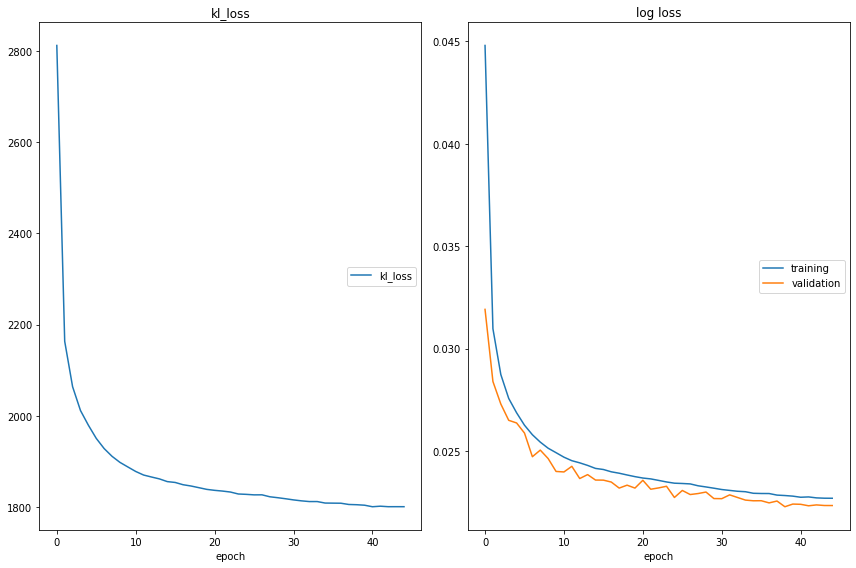

kl_loss
	kl_loss          	 (min: 1800.420, max: 2812.092, cur: 1800.497)
log loss
	training         	 (min:    0.023, max:    0.045, cur:    0.023)
	validation       	 (min:    0.022, max:    0.032, cur:    0.022)


In [59]:
def train_model():
  early_stopper = EarlyStopper(patience=4, min_delta=0)
  set_seed(seed)
  model = VAE_Conv('cuda').to(device)
  print(lr)
  criterion = nn.MSELoss()
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      model, train_loss, kl_div_loss = train(model, train_loader, criterion=criterion, weight_decay=weight_decay, kl_div_on=True, epochs=n_epochs, device='cuda', lr=lr)
      
      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'kl_loss'] = kl_div_loss.item()

      validation_loss = validation(model, validation_loader, criterion=criterion, kl_div_on=True, epochs=n_epochs, device='cuda', lr=lr)
      logs['val_' + 'log loss'] = validation_loss.item()

      liveloss.update(logs)
      liveloss.draw()

      if early_stopper.early_stop(kl_div_loss.item()):             
        break

  return model

model_test = train_model()

**Saving the Model**

In [ ]:
# # import pickle

# with open('cVAE_model_3epoch.pickle', 'wb') as handle:
#     pickle.dump(model_test, handle)

In [ ]:
# import pickle

# with open('cVAE_model.pickle', 'rb') as handle:
#     model_pickle = pickle.load(handle)

**Reconstructed Images**

Below is some reconstructed images that have been genertared by the cVAE network using the validation data. The images have been reconstructed well.

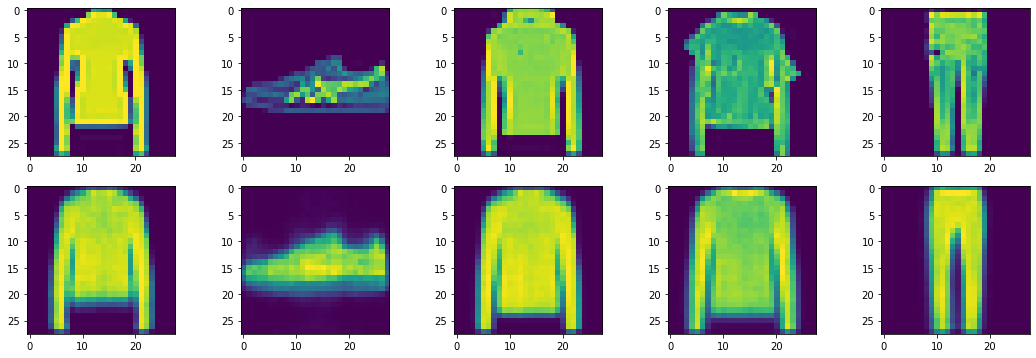

In [ ]:
images, labels = next(iter(validation_loader))
vae_conv1 = model_test.eval()
_, ax = plt.subplots(2, 5, figsize=[18.5, 6])
for n, idx  in enumerate(torch.randint(0,images.shape[0], (5,))):
  recon, _ = vae_conv1(images.cuda(), labels)
  ax[0, n].imshow(images[idx].squeeze())
  ax[1, n].imshow(recon[idx].cpu().detach().squeeze())

**User Generated Images** 

Below a sample of images produced by specifying the class is shown. It can be seen that the images resemble their respective classes well.

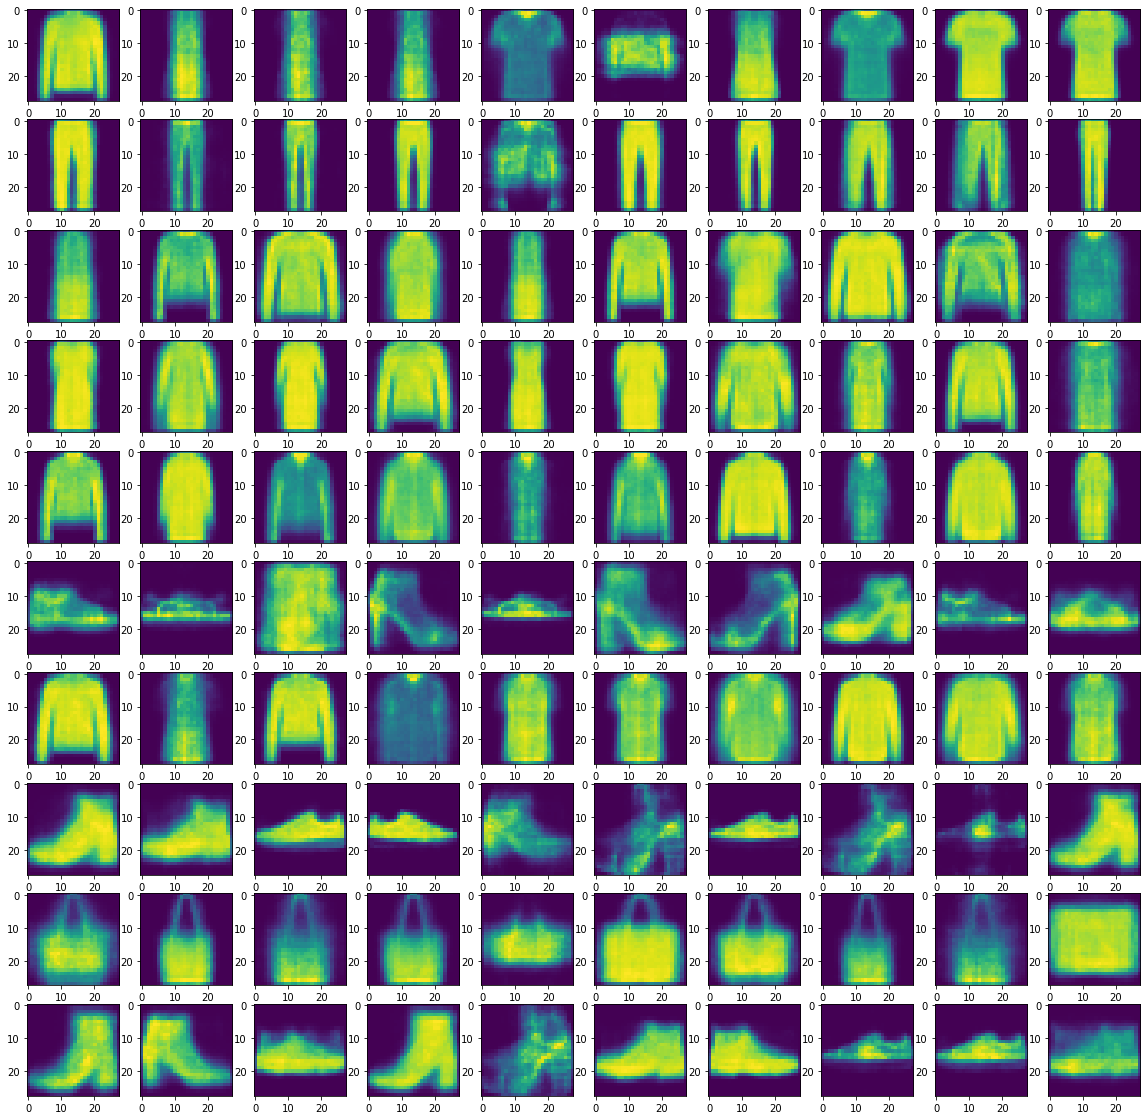

In [ ]:

with torch.no_grad():
  eval_model = model_test.eval()
  fig, axs = plt.subplots(10, 10, figsize=(20,20))
  for n in range(0,10):
    for i in range(0,10):
      #print(n, i)
      axs[n, i].imshow(eval_model.sample(n).cpu().detach().squeeze())

#plt.show()

  #axs[0,9] = plt.imshow(eval_model.sample(0).cpu().detach().squeeze())




In [ ]:
#torch.save(model.state_dict(), "./CVAE_{:03d}.pth".format())

In [ ]:
# load_state_dict(torch.load("./CVAE_{:03d}.pth".format(100)))

<br>

---

<br>

## **Q3** - Implement a **conditional GAN** that generates a user-defined class [25 points]

Implement a GANs similar to the one we saw in class but with the following modifications:

- Your new network should generate samples of any class defined by the user, that is, when you run your generator, you have to tell it which class you want it to generate. <br> *During the lectures we created a GAN that would generate samples of any class, we did not have control over which class would be generated. The exercise is to modify the network, training loops, and anything else you consider necessary, so that, once is trained, you can generate images of any particular class specified when you run your generative model.*

- Expand your network to include **at least two** of the following modifications. Choose them based on what you think will result in better network performance (make sure to justify your choices well, argumenting why did you decide to include your particular modifications):
  - Convolutional layers
  - Data augmentation
  - Different activations
  - Different random seed
  - Other network modifications that are well justified. <br> *You have freedom to choose what to do here, but your marks will depend not only on the correct implementation but also on the justification of your choices.*

- Use your trained conditional GAN to **generate and plot 10 new samples of each class** by adding the class label to your random input (in any form you have implemented it).

- You **DO NOT** have to optimise any hyperparameters, but if you had to choose three hyperparameters to optimise:
  - Which ones would you choose and why?
  - Would they be different from your choices in **Q2**?


Generate information of your training process (liveloss plots, or any other data that will help you understand your results and analyse them in the last question **Q4**).

In [22]:
train_transforms = transforms.Compose([transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5), std=(0.5))])

In [23]:
train_dataset = torchvision.datasets.FashionMNIST('./', train=True, transform=train_transforms, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./', train=False, transform=test_transforms, download=True)

**Building the Generator and Discriminator**

When building both the generator and discriminator, it is extremely important that the balance between "power" or complexity of the two networks are roughly similar. If this isn't the case, the discriminator will often return 0 loss, indicating that it is a lot stronger than the generator.

referenced: https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/


In [166]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.label_embedding = nn.Sequential(nn.Embedding(10, 50), # embedding dim to match the 
                                             nn.Linear(50, 16)) # scale up to image dimension with linear layer
         
        self.latent = nn.Sequential(nn.Linear(100, 512),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(512, 1024),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Linear(1024, 8192),
                                   nn.LeakyReLU(0.2, inplace=True))                              
        
        self.model = nn.Sequential(nn.ConvTranspose2d(513, 256, 3, 1, 1, bias=False), # output 4x4
                      nn.BatchNorm2d(256, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(256, 128, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(128, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(128, 64, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=3,bias=False),
                      nn.Tanh())
                                    
 
    def forward(self, x, y):
        x = x.to(device)
        y = y.to(device)
        if y.dtype is torch.float32:
          y = y.to(torch.int32)
        else:
          pass
        y_embed = self.label_embedding(y)
        y_embed = y_embed.view(-1, 1, 4, 4)
        x = self.latent(x)
        x = x.view(-1, 512, 4, 4)
        x_y = torch.cat((x, y_embed), dim=1) # make sure this is over the channel
        x_y = self.model(x_y)

        return x_y
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_embedding = nn.Sequential(nn.Embedding(10, 100), # embedding the labels to a 50 element vector
                                            nn.Linear(100, 28*28)) # scale up to image dimension with linear layer
            
            
        self.model = nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Linear(512, 4608),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1),
                      nn.Sigmoid()
                     )
        
    
    def forward(self, x, y):
      x = x.to(device)
      y = y.to(device)
      if y.dtype is torch.float32:
        y = y.to(torch.int32)
      else:
        pass
      y_embed = self.label_embedding(y)
      y_embed = y_embed.view(-1, 1, 28, 28)
      x_y = torch.cat((x,y_embed), dim=1) # concat as a channel
      x_y = self.model(x_y)
      return x_y


# build model
G = Generator().to(device)
D = Discriminator().to(device)

**Define Loss function and Hyperparams**

In [168]:
criterion = nn.BCELoss() 
z_dim = 100
bs = 100 ## batch_size

# optimiser
lr = 0.00005
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

**Reload in the data**

In [150]:
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
validation_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

text block for your answers

In [151]:
#---------------- altering for new model ---------------------

def D_train(x, y_label):

    D.train() # set to train
    D_optimizer.zero_grad() # reset grad

    x_real = x 

    y_real = torch.ones((x.size(0), 1)).to(device) # create vector of 1's (real)
    y_fake = torch.zeros((x.size(0), 1)).to(device) # create vector of 0's (fake)

    # Real Output from discrim + loss
    D_output = D(x_real, y_label) # take in the image and the label
    D_real_loss = criterion(D_output, y_real) # check if discriminator can determine if real

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    # create fake data with Generator
    x_fake = G(z, y_label) 

    # pass fake generated image into the discriminator with the real label
    D_output = D(x_fake.detach(), y_label)
    # loss if discrim can determine its fake
    D_fake_loss = criterion(D_output, y_fake)

    # accumulated loss
    D_loss = (D_real_loss + D_fake_loss)

    # model update 
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [152]:
def G_train(x, y_label):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimizer.zero_grad()

    # sample vector and produce generator output
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z, y_label)

    # obtain scores from D for the generated data
    D_output = D(G_output, y_label)

    # train generator to "fool" discriminator
    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)

    # model update 
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

**Training and Plotting of the cGAN**

Below we train the model - I have trained the model on only 20 Epochs, I would have like to have trained it more however, the initialisation of the model/choosing oh hyperparamters was very sensetive.

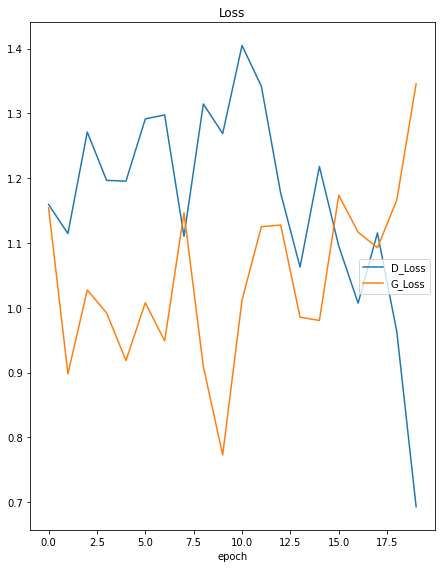

Loss
	D_Loss           	 (min:    0.693, max:    1.405, cur:    0.693)
	G_Loss           	 (min:    0.773, max:    1.346, cur:    1.346)


In [169]:
def train_gan():
    #set_seed(123)
    G = Generator().to(device)
    D = Discriminator().to(device)
    n_epoch = 20 
    groups = {'Loss': ['D_Loss', 'G_Loss']}
    liveloss = PlotLosses(groups=groups)

    for epoch in range(1, n_epoch+1):  
      D_losses, G_losses = [], []
      logs = {}
      for batch_idx, (x, y) in enumerate(train_loader):
        D_loss, G_loss = D_train(x, y), G_train(x, y)
        logs['D_Loss'] = D_loss
        logs['G_Loss'] = G_loss
      liveloss.update(logs)
      liveloss.draw()

      #save every 20th epochs
      if(np.mod(epoch, 20) == 0):
        torch.save(G.state_dict(), "./drive/MyDrive/cGAN_{:03d}.pth".format(epoch))

    return G

G = train_gan()

**Grid Plot of Images**

As it can be seen my cGAN was unsuccessful. This may be a result of the network being too complicated to efficiently train, or too little epochs to train.

torch.Size([1, 1, 28, 28])


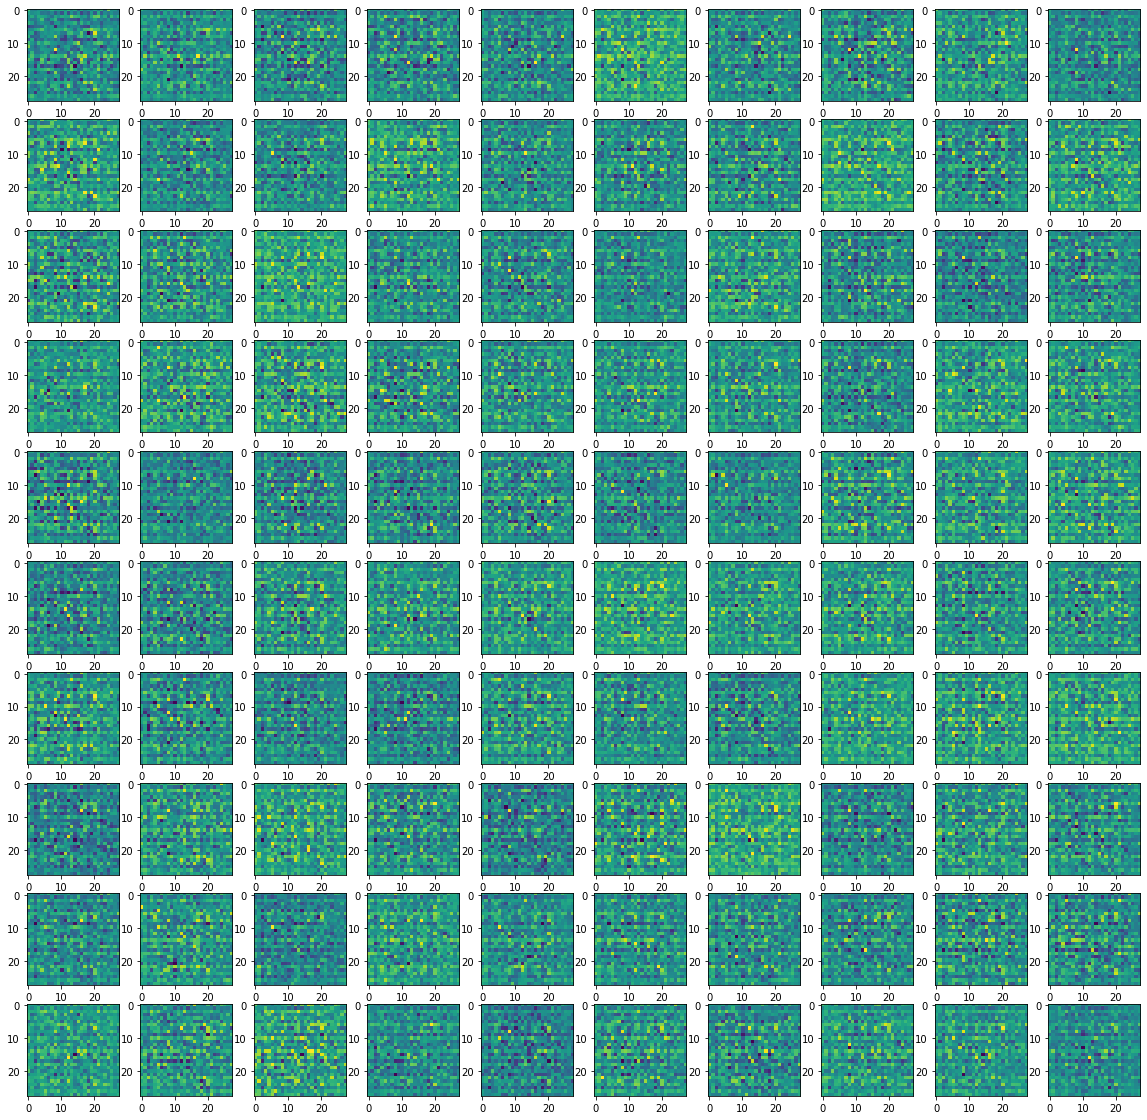

In [189]:
with torch.no_grad():
  eval_GAN = G.eval()
  test=eval_GAN(torch.randn(1, 100).to(device), torch.tensor(2))
  print(test.shape)
  fig, axs = plt.subplots(10, 10, figsize=(20,20))
  for n in range(0,10):
    for i in range(0,10):
      #print(n, i)
      sample_z = torch.randn(1, 100).to(device)
      sample = eval_GAN(sample_z, torch.tensor(n))
      #print(sample.view(1,28,28).shape)
      axs[n, i].imshow(sample.squeeze().detach().cpu())

text block for your answers

<br>

---

<br>

## **Q4** - Analysis and comparison of results [20 points]

Analyse and compare the results you have obtained with the two networks above.

- Use the data you generated training the three networks above to discuss the results you have generated in **Q2** and **Q3**.
- Is there a network that performs better than the other? Why do you think that is?
- What could you do to improve your results on each of the networks you have implemented? ***\[limit your answer to this question to 150 words\]***

**IMPORTANT NOTE**: even if you did not complete **Q2** and **Q3**, make sure to include a discussion with any partial results or other considerations regarding the performance of your implemented methods.

**Q2 cVAE Discussion**

The results for the cVAE autoencoder are very promising. We can see from the livelossplots for both the pixel wise loss and KL-Divergance loss that the model is training well. I have experiemented with different learning rates and learning decays and found that the model will typically convergew to a loss of around 0.22. Intrestingly, I found that normalising the data prior to training results in poorer performance. This may be because of the natural exisiting distribution of the data and because the data is grayscaled so it is already standardised.

The sample of images plot successfully and they resemble their respective classes well.

**Q3 cGAN Discussion**

The results of this model seem to be a lot poorer than that of the cVAE. Firstly, there seems to be a power/complexity balance issue between my generator and the discriminator. Often times when I exectue the training, the discriminator will plateua at 0 while the generator's loss will continue to increase. I attemped to resolve this by modifying the complexity of the discriminators layers. I found that this did not solve the issue so I focused on making the generator more complex. 

After I made these modifications the models loss looks more appropiate, however, the training can still be very unpredictable.

Overall, my model was not very successful. I believe the complexity of my network limited how well the network could converge.

**Comparision**

The cVAE significantly outpeforms my cGAN. I believe this is because I could not find a reliable way to train the cGAN. I experiemented with different random seeds to initalise the network better, however, I did not succeed with this. As a result I decided to not use a random seed and opt to re-initialise the network until it was clear that both the discriminator and GAN were learning correctly.

because cVAE's overall are more stable with training and often converge faster, and have clear stopping criteria.

**How would I improve my results**

Firstly, I would aim to implement a wassterstien weighting to the model following this paper https://cameronfabbri.github.io/papers/conditionalWGAN.pdf. I believe that this would increase the training stability and provide loss curves that convey more information as to how the model is training.

Secondly, I would aim to fine-tune the hyperparamters for both the networks. Through some testing I found that both networks were extremely sensetive to hyperparams such LR and batch size (more so with my cGAN).

Finally, I would experiment more with different activation functions and see how they can improve the networks.

text block for your answers

<br>

---

<br>

## **Q5** - Modify your dataset to create data imbalance and retrain **one** of your conditional models [20 points]

Modify the `FashionMNIST` dataset to eliminate 90% of the images corresponding to one of the classes in the dataset (whichever you want).

Now, **choose one of the two questions below (a or b)**:

- **Q5-a) Retrain your conditional VAE from scratch** with this new dataset, and after training, use it to generate 10 images for the class you have decimated.

- **Q5-b) Retrain your conditional GAN from scratch** with this new dataset, and after training, use it to generate 10 images for the class you have decimated.

- Compare the results of this new images generated with the modified dataset with the original results from questions **Q2** or **Q3** (depending of whether you have chosen **Q5-a** or **Q5-b**). What do you observe? Describe your interpretation of this comparison.

In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5), std=(0.5))])

text block for your answers

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('./', train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST('./', train=False, download=True)

**Removing 90% of class 9**

Below we remove 90% of class 9. We verify this by returning the length of the dataset to find that only 54600 images remain, indicating that it was successful.text block for your answers

In [ ]:
idx_to_keep = (train_dataset.targets!=9).detach().numpy()
print(len(idx_to_keep))
print(range(len(idx_to_keep)))

counter = 0
for i in range(len(idx_to_keep)):
  if idx_to_keep[i] == False:
    idx_to_keep[i] = True
    counter += 1
    if counter >= 600:
      break
  else:
    pass

train_dataset.targets = train_dataset.targets[idx_to_keep]
train_dataset.data = train_dataset.data[idx_to_keep]

print(len(train_dataset))

**Training the cVAE**

We will train the cVAE on the reduced dataset with the hyperparams listed below

In [ ]:
seed = 42
lr = 0.001
batch_size = 64
test_batch_size = 1000
n_epochs = 20
weight_decay = 1e-6

Final result can be seen below

In [ ]:
print(len(train_dataset))
cVAE_model_less = train_cVAE()

In [ ]:
with torch.no_grad():
  eval_model = model_test.eval()
  fig, axs = plt.subplots(10, 10, figsize=(20,20))
  for n in range(0,10):
    for i in range(0,10):
      #print(n, i)
      axs[n, i].imshow(eval_model.sample(n).cpu().detach().squeeze())

**Interpretation of Results**

Looking at these results it is clear that the (reduced/full) dataset performs better. 